# Validation

We check the `Bandit` and `BernouilliArm` are properly implemented, by using
the `Oracle` to evaluate some `RandomPolicy` on this problem.

In [1]:
from project.bandit import Bandit, BernouilliArm

bandit = Bandit.generate(
    arm_class=BernouilliArm,
    arm_kwargs=(
        {'p': 0.1},
        {'p': 0.4},
        {'p': 0.6},
        {'p': 0.8},
        {'p': 0.9},
    )
)

In [2]:
from project.policy import RandomPolicy

n_policies = 3

policies = [
    RandomPolicy() for _ in range(n_policies)
]

In [3]:
from project.oracle import Oracle

oracle = Oracle(policies=policies)

In [4]:
oracle.set_bandit(bandit=bandit)

In [9]:
n_runs = 400
report = oracle.evaluate(
    n_runs=n_runs
)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

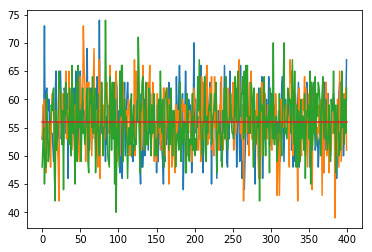

In [14]:
for i in range(n_policies):
    plt.plot(np.sum(report.results[:,i,:], axis=1))

avg_reward = np.mean([arm.p for arm in bandit.arms])
plt.plot(avg_reward * 100 * np.ones(n_runs))

# Gittins Index

$$\mathcal{G}_k(x_{k,t}) = \sup_{\tau \geq 1} \Big( \frac{\sum_{i=0}^{\tau - 1} \lambda_{k, t+i} \, d^i}{\sum_{i=0}^{\tau - 1} d^i} \quad | \; x_{k,t} \Big)$$

$$\lambda_{k,t} = \frac{s_{k,0} + s_{k,t}}{s_{k,0} + s_{k,t} + f_{k,0} + f_{k,t}}$$

**Computation method** (Largest-Remaining-Index algorithm, Varaiya, Walrand and Buyukkoc):

- Find state $x = (s, f)$ with highest expected reward $\lambda = \frac{s}{s + f}$, call it $\alpha_1$.
- For each $k$ from $2$ to $m$ (the number of considered states):
    - Compute $Q^{(k)}$ from the transition probability matrix $P$, keeping only the columns for the continuation set of $\alpha_k$, which is $(\alpha_1, \dots, \alpha_{k-1})$.
    - Compute the inverse $C^{(k)} = (I - \beta Q^{(k)})^{-1}$ (probably sparse ?)
    - Then, compute $d^{(k)} = C^{(k)} \cdot \lambda$ and $b^{(k)} = C^{(k)} \cdot 1$ (these are $m$-vectors)
    - Find the best state $a = \alpha_k$ when maximizing $\frac{d^{(k)}_a}{b^{(k)}_a}$

$$Q^{(k)}_{x, y} = 0 \; \text{when}\;  y \notin (\alpha_1, \dots, \alpha_{k-1}) \cap \mathcal{F}(x) \quad\quad \text{where} \; \mathcal{F}(x = (s, f)) = \{(s + 1, f), (s, f + 1)\}$$

Let's try to simplify the way we choose...

At step $k$, we have $m - k + 1$ candidates for $\alpha_k$. We only keep the ones in the set of predecessors for the currently saved set of states $(\alpha_1, \dots, \alpha_{k-1})$, which we note: 

$$\mathcal{P}(\alpha_1, \dots, \alpha_{k-1}) = \bigcap_i \{(s_{\alpha_i} - 1, f_{\alpha_i}), (s_{\alpha_i}, f_{\alpha_i} - 1)\} \,\backslash\, \{\alpha_1, \dots, \alpha_{k-1}\}$$

We compute $(I - \beta Q^{(k)})$ by substracting $\beta \, \mathbb{P}(\alpha_j \, | \, x)$ whenever we find a predecessor $x$ to $\alpha_j$.

Let's compute $P$:  

Suppose we have $s, f \in \{1, \dots, n\}$, then $P$ is of size $n^2 \times n^2$.  
if we note $x = n s + f$, then the row $P_x$ only contains zeros, except for $y = n s + (f + 1)$ and $y = n (s + 1) + f$

Visualizing this matrix, we can see it only shows two non-zero subdiagonals, one with an offset of 1 from the diagonal, representing the probability of failure, and another one with an offset of $n$ from the diagonal representing the successes.

First non-zero subdiagonal (offset 1) : $$P_{x, x+1} = \frac{f}{s + f} \forall s \in \{1, \dots, n\}, f \in \{1, \dots, n - 1\}$$

Second non-zero subdiagonal (offset $n$) : $$P_{x, x+n} = \frac{s}{s + f} \forall s \in \{1, \dots, n - 1\}, f \in \{1, \dots, n\}$$

In [3]:
def transition_prob(state_from, state_to):
    s_from, f_from = state_from
    s_to, f_to = state_to
    
    if (s_to - s_from) + (f_to - f_from) != 1:
        return 0
    elif s_to - s_from == 1:
        return s_from / sum(state_from)
    else:
        return f_from / sum(state_from)

In [4]:
def gen_states(n_steps):
    for n_success in range(1, n_steps + 1):
        for n_failure in range(1, n_steps + 1):
            yield (n_success, n_failure)

In [5]:
gen = gen_states(10)
for i in range(20):
    print(next(gen))

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)


In [53]:
n_steps = 150

n_states = (
    n_steps *  # maximum number of successes
    n_steps    # maximum number of failures
)

first_diag = [
    n_failure / (n_success + n_failure)
    for n_success, n_failure in gen_states(n_steps)
][:-1]

second_diag = [
    n_success / (n_success + n_failure)
    for n_success, n_failure in gen_states(n_steps)
][:-n_steps]

In [7]:
from scipy import sparse
import numpy as np

In [8]:
data = np.zeros((2, n_states))
data[0, :-1] = first_diag
data[1, :-n_steps] = second_diag
offsets = [1, n_steps]

transition_matrix = sparse.dia_matrix(
    (data, offsets), shape=(n_states, n_states)
)

In [9]:
transition_matrix

<2500x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 4949 stored elements (2 diagonals) in DIAgonal format>

So we have the transition matrix $P$, but we actually want $(I - \beta Q)$. To build it, we'll consider the following approach:

- Start with the identity matrix
- Given the set of kept states at iteration $k$ (we note it $\mathcal{S}^{(k)} = \{\alpha_1, \dots, \alpha_{k-1}\}$), we compute the set of predecessor states $\mathcal{P}(\mathcal{S}^{(k)})$
- For each predecessor $(s, f)$, we compute the related $Q$ entries, and update the subdiagonals accordingly

In [93]:
def check_pred(state, successors):
    if state in successors:
        # already seen
        return False
    
    if state[0] < 0 or state[1] < 0:
        # out of the grid
        return False
    
    return True

def get_predecessors(states):
    assert isinstance(states, set), "Expected the kept states to be a set."
    
    predecessors = set()
    for state in states:
        s_pred = (state[0] - 1, state[1])
        f_pred = (state[0], state[1] - 1)
        
        if check_pred(s_pred, states):
            predecessors.add(s_pred)
        
        if check_pred(f_pred, states):
            predecessors.add(f_pred)
    
    return predecessors

In [96]:
# let's call `c_mat` the (I - beta Q) matrix

def compute_c_mat(n_steps, states, beta=0.9):
    n_states = n_steps ** 2
    # we start with the identity matrix
    c_mat = sparse.dia_matrix((np.ones(n_states), [0]), shape=(n_states, n_states))
    
    # initialize empty subdiagonals
    subdiag_to_failure = np.zeros(n_states)
    subdiag_to_success = np.zeros(n_states)
    
    for pred in get_predecessors(states):
        s, f = pred
        pred_index = n_steps * s + f

        if (s, f + 1) in states:
            subdiag_to_failure[pred_index] = (f + 1) / (s + f + 2)
        
        if (s + 1, f) in states:
            subdiag_to_success[pred_index] = (s + 1) / (s + f + 2)
    
    c_mat.setdiag(-beta * subdiag_to_failure, 1)
    c_mat.setdiag(-beta * subdiag_to_success, n_steps)
    
    return c_mat.tocsc()  # use Compressed Sparse Column format for inversion

In [54]:
n_steps = 150

n_states = (
    n_steps *  # maximum number of successes
    n_steps    # maximum number of failures
)

# find alpha_1
alpha_1 = sorted(
    ((state, state[0]/sum(state)) for state in gen_states(n_steps)),
    key=lambda t: t[1]
)[-1][0]

alpha_1 = (alpha_1[0] - 1, alpha_1[1] - 1)  # 0-indexed arrays

In [55]:
current_states = set([alpha_1])

In [56]:
%%time
c_mat_2 = compute_c_mat(current_states)

CPU times: user 5.01 ms, sys: 0 ns, total: 5.01 ms
Wall time: 5.71 ms


In [43]:
import scipy.sparse.linalg as s_linalg

In [57]:
%%time
inv_c_mat_2 = s_linalg.inv(c_mat_2)

CPU times: user 16.2 s, sys: 8.02 ms, total: 16.2 s
Wall time: 16.2 s


In [58]:
_lambda = np.array([
    (x[0] / sum(x)) for x in gen_states(n_steps)
])

In [60]:
d_2 = inv_c_mat_2.dot(_lambda)

In [61]:
b_2 = inv_c_mat_2.dot(np.ones(n_states))

In [64]:
np.argmax(d_2 / b_2)

22350

In [65]:
n_states

22500

In [99]:
from contextlib import contextmanager
import time

@contextmanager
def timeit(key: 'default', debug=False):
    start = time.time()
    yield
    duration = time.time() - start
    if debug:
        print('({}): {:.2f}s'.format(key, duration))

In [105]:
def compute_gittins_index(n_steps, beta=0.9):
    n_states = (
        n_steps *  # maximum number of successes
        n_steps    # maximum number of failures
    )
    rewards = np.array([
        x[0] / sum(x) for x in gen_states(n_steps)
    ])
    ones = np.ones(n_states)
    
    best_states = set()
    gittins = np.zeros((n_steps, n_steps))
    
    # find the best rewarding state (alpha 1)
    alpha_1 = np.argmax(rewards)
    alpha_1_state = (alpha_1 // n_steps, alpha_1 % n_steps)
    
    best_states.add(alpha_1_state)
    gittins[alpha_1_state] = rewards[alpha_1]
    
    for i in range(1, n_states):
        if i % 100 == 99:
            print("Step {}/{}".format(i + 1, n_states))
        
        with timeit('compute C - step {}'.format(i)):
            c_mat = compute_c_mat(n_steps, best_states, beta)
        
        with timeit('inverse C - step {}'.format(i)):
            try:
                inv_c_mat = s_linalg.inv(c_mat)
            except:
                print(c_mat.todense())
                print(best_states)
                print(get_predecessors(best_states))
                break
        
        d = inv_c_mat.dot(rewards)
        b = inv_c_mat.dot(ones)
        d_b = d / b
        
        # mask d_b for seen states
        for s, f in best_states:
            d_b[n_steps * s + f] = 0
        
        new_best = np.argmax(d_b)
        new_best_state = (new_best // n_steps, new_best % n_steps)
        
        #print('New best state: {} (s={}, f={})'.format(new_best, *new_best_state))
        #print('Gittins value for {}: {}'.format(new_best, d_b[new_best]))
        
        best_states.add(new_best_state)
        gittins[new_best_state] = d_b[new_best]
    
    return gittins

In [110]:
gittins = compute_gittins_index(20, 0.99)

Step 10/400
Step 20/400
Step 30/400
Step 40/400
Step 50/400
Step 60/400
Step 70/400
Step 80/400
Step 90/400
Step 100/400
Step 110/400
Step 120/400
Step 130/400
Step 140/400
Step 150/400
Step 160/400
Step 170/400
Step 180/400
Step 190/400
Step 200/400
Step 210/400
Step 220/400
Step 230/400
Step 240/400
Step 250/400
Step 260/400
Step 270/400
Step 280/400
Step 290/400
Step 300/400
Step 310/400
Step 320/400
Step 330/400
Step 340/400
Step 350/400
Step 360/400
Step 370/400
Step 380/400
Step 390/400
Step 400/400


In [113]:
gittins[0:5, 0:5].T

array([[ 0.55518395,  0.6997992 ,  0.7713056 ,  0.81473214,  0.84409654],
       [ 0.37468672,  0.53311037,  0.62484316,  0.68559954,  0.7290795 ],
       [ 0.27975952,  0.42836676,  0.52365026,  0.59078467,  0.64092664],
       [ 0.22203673,  0.35696384,  0.44984955,  0.51839465,  0.57132616],
       [ 0.18352749,  0.30540089,  0.39380128,  0.46141975,  0.51505017]])